In [1]:
#import sys
#sys.path.append("/home/klar/Promotion/projects/nonlocal-assembly")

# Setting

Let $\Omega = B_1$ and $\Omega_I = B_{1+\delta}\setminus B_1$, and $\overline{\Omega} = \Omega \cup \Omega_I$.
We are given $n$ Ansatzfunctions
$$
\Phi = (\phi_1, \phi_2)  \in \mathcal{L}(\overline{\Omega})^2.
$$
in a discretization of a 2-D Grid.

### Configuration

In [2]:
from duffyconf import *
import meshio
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mesh = meshio.read(DATA_PATH + mesh_name)

### Ansatz function

In [4]:
class V:
    def __init__(self, mesh):
        self.points = mesh.points[:,:2]
        self.N = self.points.shape[0]
        self.triangles = mesh.cells[1][1]
        
    def phi1(self, p):
        return 1 - p[0] - p[1]
    
    def phi2(self, p):
        return p[0]
    
    def phi3(self, p):
        return p[1]
    
    def __getitem__(self, k):
        phi = [self.phi1, self.phi2, self.phi3]
        #n, k = index
        return phi[k]
    
    def plot(self):
        plt.scatter(self.points[:,0], self.points[:,1], s=.1)
        plt.scatter(0,0)
        plt.show()
    
class T:
    def __init__(self, mesh):
        self.triangles = mesh.cells[1][1]
        self.points = mesh.points[:,:2]
        self.N = self.triangles.shape[0]
        self.tris = []
        for k in range(self.N):
            Vdx = self.triangles[k]
            a,b,c = np.array(self.points[Vdx])
            self.tris.append(Triangle(a,b,c))
    def __getitem__(self, k):
        return self.tris[k]
    
class Triangle:
    def __init__(self, a,b,c):
        self.M = np.array([b-a, c-a]).T
        self.det = np.abs(np.linalg.det(self.M))
        self.E = np.array([a,b,c])
        self.a = a
        self.b = b
        self.c = c
        
    def __call__(self, x):
        return self.M@x + self.a
def C(z):
    return np.outer(z,z)

def kernel(x,y):
    z = x-y
    d = np.linalg.norm(z)
    if d>1e-6:
        return 1./d**3
    else:
        print("Zero Division!")
        return 1.
    
def kernel1D(x,y):
    z = x-y
    d = np.linalg.norm(z)
    if d>1e-6:
        return 1./d
    else:
        print("Zero Division!")
        return 1.

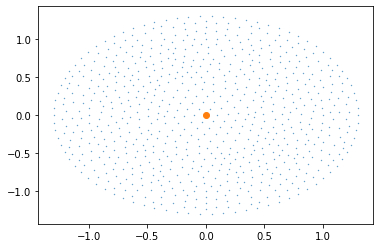

In [5]:
Ansatz = V(mesh)
Triangles = T(mesh)

Ansatz.plot()

### Integral Kernel 1D

We set $\delta = 0.3$.

As warm up we simply integrate the circle weighted with the kernel for $x = (0,0)$. The analytic solution is obtained by.
$$
\sum_{A \in \mathcal{T}} \int_A \frac{1}{\|x-y\|} dy
$$
Where the analytic solution is given by
$$
\int_{B_{1+\delta}} \frac{1}{\|z\|} dz = 
\int_0^{1+\delta} \int_0^{2\pi} \frac{r}{r} d\phi dr = (1+\delta) 2 \pi. 
$$

as the determinant of the Jacobian is $r$ for $\phi: (r, \phi) \mapsto r (sin(\phi), cos(\phi))$ .

In [6]:
x = np.zeros((2,))
integral = 0.

for k in range(Triangles.N):
    tri = Triangles[k]
    n = dy.shape[0]
    s = 0
    for i in range(n):
        y = tri(Py[i])
        s += kernel1D(x, y)*tri.det*dy[i]
    integral += s
print("Integral\t", integral)
print("True value\t", 2*np.pi*(1+delta))

Integral	 8.151759178074103
True value	 8.168140899333462


### Integral Kernel 2D

We set $\delta = 0.3$.

Now we integrate the simplest version of the peridynamics-kernel for $x = (0,0)$. The analytic solution is obtained by.

$$
\sum_{A \in \mathcal{T}} \int_A \frac{(x-y) \otimes (x-y)}{\|x-y\|^3}  dy = \textbf{I}
$$
Where the analytic solution is given by
$$
\textbf{I}_{2,2} = \textbf{I}_{1,1} = \int_{B_{1+\delta}} \frac{z_1^2}{\|z\|} dz = 
\int_0^{1+\delta} \int_0^{2\pi} \frac{sin^2(\phi) r^2}{r^3}r d\phi dr = (1+\delta) \int_0^{2\pi}sin^2(\phi) d\phi. 
$$
$$
= (1+\delta) \left[ \frac{1}{2}(\phi - sin(\phi)cos(\phi) \right]_0^{2\pi} = (1+\delta)\pi. 
$$
and
$$
\textbf{I}_{2,1} = \textbf{I}_{1,2} = \int_{B_{1+\delta}} \frac{z_1 z_2}{\|z\|} dz = 
\int_0^{1+\delta} \int_0^{2\pi} \frac{sin(\phi)cos(\phi) r^2}{r^3}r d\phi dr = (1+\delta) \int_0^{2\pi}sin(\phi)cos(\phi) d\phi = 0. 
$$

In [7]:
x = np.zeros((2,))
integral = 0.
Det = np.zeros(Triangles.N)
for k in range(Triangles.N):
    tri = Triangles[k]
    s = 0
    n = dy.shape[0]
    for i in range(n):
        y = tri(Py[i])
        s += C(x-y)*kernel(x, y)*tri.det*dy[i]
    integral += s
print("Integral\n", integral)
print("\nTrue value\n", np.eye(2)*np.pi*(1+delta))

Integral
 [[4.07635907e+00 7.59845636e-04]
 [7.59845636e-04 4.07540011e+00]]

True value
 [[4.08407045 0.        ]
 [0.         4.08407045]]


### Double Integral where $A \cap B = \emptyset$

In this (most frequent) case the Triangles have positve distance and we can use the quadrature given above to evaluate the double integral
$$
    \int_A \int_B \frac{(x-y) \otimes (x-y)}{\|x-y\|^3}  dy dx = \textbf{I}
$$

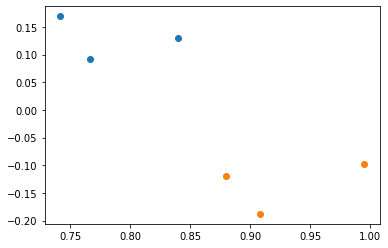

In [8]:
A = Triangles[0]
plt.scatter(A.E[:,0], A.E[:,1])

B = Triangles[4]
plt.scatter(B.E[:,0], B.E[:,1])
plt.show()   

In [9]:
nx = dx.shape[0]
ny = dy.shape[0]

integral = 0
for k in range(nx):
    x = A(Px[k])
    for i in range(ny):
        y = B(Py[i])
        integral += C(x-y)*kernel(x, y)*B.det*A.det*dy[i]*dx[k]
    
print("Integral\n", integral)
print("\nTrue value\n ??")

Integral
 [[ 1.10826805e-05 -1.93706756e-05]
 [-1.93706756e-05  3.62027571e-05]]

True value
 ??


### Double Integral where $A \cap B = \{v_0\}$

In this case the Triangles share one point. The given qudrature rule still allows to integrate the triangles without zero division, however there is a singularity *at the tip of the triangles*.
$$
    \int_A \int_B \frac{(x-y) \otimes (x-y)}{\|x-y\|^3}  dy dx = \textbf{I}
$$
We will use the naive integral as test case for the transformed version.

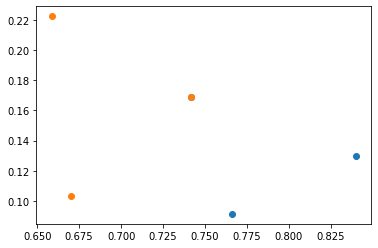

In [10]:
A = Triangles[0]
plt.scatter(A.E[:,0], A.E[:,1])
B = Triangles[224]
plt.scatter(B.E[:,0], B.E[:,1])
plt.show()

In [11]:
nx = dx.shape[0]
ny = dy.shape[0]

integral = 0
for k in range(nx):
    x = A(Px[k])
    for i in range(ny):
        y = B(Py[i])
        integral += C(x-y)*kernel(x, y)*B.det*A.det*dy[i]*dx[k]
    
print("Integral\n", integral)
print("\nTrue value\n ??")

Integral
 [[ 1.36128942e-04 -4.48901554e-05]
 [-4.48901554e-05  3.01923539e-05]]

True value
 ??


### Double Integral where $A \cap B = \{v_0, v_1\}$

This case is more interesting...

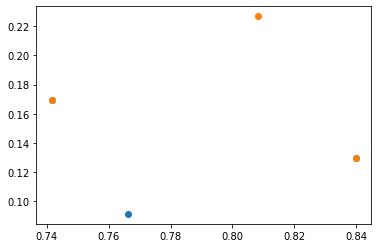

In [12]:
A = Triangles[0]
plt.scatter(A.E[:,0], A.E[:,1])

B = Triangles[2]
plt.scatter(B.E[:,0], B.E[:,1])
plt.show() 